In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append("..")

from src.pickle_manager import open_parquet
from src.evaluation import plot_confusion_matrix

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def get_date(reg_date: pd.Timestamp, ogrn: int, msp_date: pd.Timestamp) -> pd.Timestamp:
    """Apply reg_date using year calculated from ogrn"""
    if pd.isnull(reg_date) and msp_date == datetime.datetime(2016, 8, 1):
        reg_date = datetime.datetime(int("20" + str(ogrn)[1:3]), 8, 10)
    elif pd.isnull(reg_date) and msp_date != datetime.datetime(2016, 8, 1):
        reg_date = msp_date
    return reg_date

In [3]:
def classify_lifetime(lifetime):
    """Classify lifetime into categories."""
    if lifetime <= 24:
        return 0
    elif 24 < lifetime <= 120:
        return 1
    elif lifetime > 120:
        return 2

In [4]:
def inverse_classify_lifetime(category: int):
    """Return the range of lifetimes for a given category."""
    if category == 0:
        return 24
    elif category == 1:
        return 120
    elif category == 2:
        return float('inf')
    else:
        return None

In [5]:
init_data = open_parquet("../data/parquet", "companies_feat_open.parquet")
predictions_classification = open_parquet("../results", "predicts_2023-12-13_07-28-07.parquet")
predictions_regression = open_parquet("../results", "predicts_2023-12-13_07-14-04.parquet")

In [6]:
tqdm.pandas()
init_data["reg_date"] = init_data.progress_apply(
    lambda row: get_date(row["reg_date"], row["ОГРН"], row["Дата включения в реестр"]),
    axis=1,
)

100%|██████████| 5748961/5748961 [02:05<00:00, 45914.00it/s] 


In [9]:
init_data["current_lifetime"] = (
    datetime.now().year - init_data["reg_date"].dt.year
) * 12 + (datetime.now().month - init_data["reg_date"].dt.month)

In [10]:
max_trained_llifetime = (datetime.now().year - 2000) * 12 + datetime.now().month - 1

In [11]:
init_data = init_data[init_data["current_lifetime"] < max_trained_llifetime]

In [12]:
init_data = init_data[["ОГРН", "current_lifetime"]]

In [34]:
predictions_classification = pd.merge(
    left=init_data, right=predictions_classification, how="inner", left_on="ОГРН", right_on="ogrn"
)
predictions_regression = pd.merge(
    left=init_data, right=predictions_regression, how="inner", left_on="ОГРН", right_on="ogrn"
)

### Regression

In [35]:
predictions_regression.drop(columns=["ОГРН"], inplace=True, errors="ignore")
predictions_regression.head()

,current_lifetime,ogrn,Predicted Lifetime,Standard Deviation
0,9,1233400001570,31.233853,1.662201
1,9,1236900001084,29.044421,1.590546
2,9,1237700112792,32.322319,1.971584
3,9,1232800000850,31.841784,2.136221
4,9,1236900001062,28.797285,1.466352


In [40]:
sum(predictions_regression["Predicted Lifetime"] > predictions_regression["current_lifetime"]) / predictions_regression.shape[0]

0.14062431509303602

In [22]:
y_hat = predictions_regression["Predicted Lifetime"]
y  = predictions_regression["current_lifetime"]

In [ ]:
# Apply binary classification
mask_greater = y_hat >= y
mask_lesser = y_hat < y

y_hat[mask_greater] = 1
y[mask_greater] = 1

y_hat[mask_lesser] = 0
y[mask_lesser] = 1

/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.14      0.25   5748956

    accuracy                           0.14   5748956
   macro avg       0.50      0.07      0.12   5748956
weighted avg       1.00      0.14      0.25   5748956



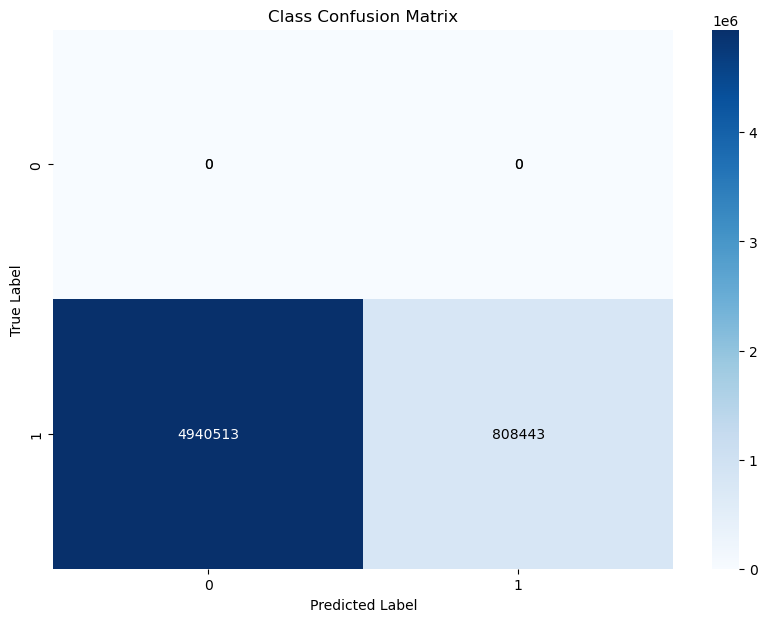

In [24]:
print(classification_report(y, y_hat))

binary_conf_mat  = confusion_matrix(y, y_hat)


plt.figure(figsize=(10, 7))
sns.heatmap(binary_conf_mat , annot=True, fmt='g', cmap='Blues')
plt.title("Class Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


ax = plt.gca()  
for i in range(binary_conf_mat.shape[0]):
    for j in range(binary_conf_mat.shape[1]):
        text = format(binary_conf_mat [i, j], 'd')
        ax.text(j+0.5, i+0.5, text, ha="center", va="center", 
                color="white" if binary_conf_mat [i, j] > binary_conf_mat .max() / 2 else "black")

plt.show()

### Classification

In [12]:
predictions_classification.drop(columns=["ОГРН"], inplace=True, errors="ignore")
predictions_classification.head()

,current_lifetime,OGRN,Predicted Class,Probabilities
0,8,1233400001570,0,"0.99, 0.01, 0.00"
1,8,1236900001084,0,"0.98, 0.02, 0.00"
2,8,1237700112792,0,"0.93, 0.07, 0.00"
3,8,1232800000850,0,"0.96, 0.04, 0.00"
4,8,1236900001062,0,"0.99, 0.01, 0.00"


In [16]:
predictions_classification["current_lifetime_classes"] = predictions_classification["current_lifetime"].apply(
    classify_lifetime
)
predictions_classification["predicted_lifetime_min"] = predictions_classification["Predicted Class"].apply(
    inverse_classify_lifetime
)

In [17]:
y_hat_classes = predictions_classification["Predicted Class"]
y_classes  = predictions_classification["current_lifetime_classes"]
y_hat = predictions_classification["predicted_lifetime_min"]
y  = predictions_classification["current_lifetime"]

In [ ]:
# Apply binary classification
mask_greater = y_hat >= y
mask_lesser = y_hat < y

y_hat[mask_greater] = 1
y[mask_greater] = 1

y_hat[mask_lesser] = 0
y[mask_lesser] = 1

              precision    recall  f1-score   support

           0       0.33      0.72      0.45   1247125
           1       0.52      0.36      0.42   2868081
           2       0.91      0.60      0.72   1633750

    accuracy                           0.50   5748956
   macro avg       0.59      0.56      0.53   5748956
weighted avg       0.59      0.50      0.52   5748956



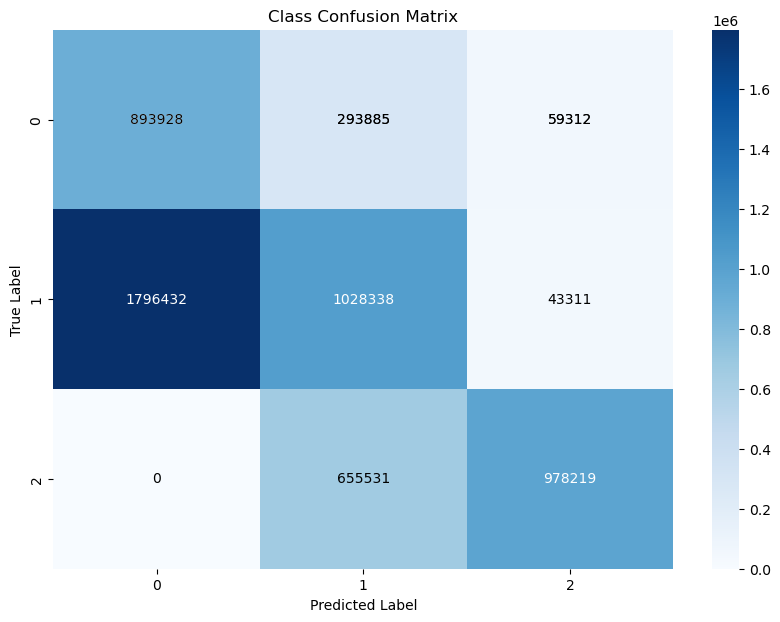

In [19]:
print(classification_report(y_classes, y_hat_classes))

class_conf_mat = confusion_matrix(y_classes, y_hat_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(class_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.title("Class Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


ax = plt.gca()  
for i in range(class_conf_mat.shape[0]):
    for j in range(class_conf_mat.shape[1]):
        text = format(class_conf_mat[i, j], 'd')
        ax.text(j+0.5, i+0.5, text, ha="center", va="center", 
                color="white" if class_conf_mat[i, j] > class_conf_mat.max() / 2 else "black")

plt.show()

/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.57      0.73   5748956

    accuracy                           0.57   5748956
   macro avg       0.50      0.29      0.36   5748956
weighted avg       1.00      0.57      0.73   5748956



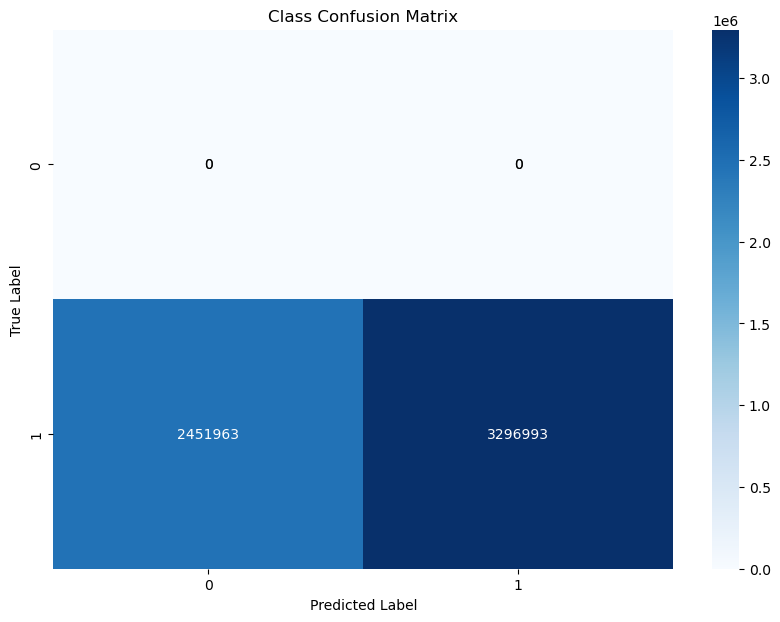

In [20]:
print(classification_report(y, y_hat))

binary_conf_mat  = confusion_matrix(y, y_hat)


plt.figure(figsize=(10, 7))
sns.heatmap(binary_conf_mat , annot=True, fmt='g', cmap='Blues')
plt.title("Class Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


ax = plt.gca()  
for i in range(binary_conf_mat.shape[0]):
    for j in range(binary_conf_mat.shape[1]):
        text = format(binary_conf_mat [i, j], 'd')
        ax.text(j+0.5, i+0.5, text, ha="center", va="center", 
                color="white" if binary_conf_mat [i, j] > binary_conf_mat .max() / 2 else "black")

plt.show()